### Executing codes from Ch. 4 on Practical Time Series book -- https://www.amazon.com/Practical-Time-Analysis-Prediction-Statistics/dp/1492041653/ref=sr_1_2?dchild=1&keywords=Time+Series+Analysis&qid=1635633849&sr=8-2

In [1]:
## membership status
years = ['2014', '2015', '2016', '2017', '2018']
memberStatus = ['bronze', 'silver', 'gold', 'inactive']

In [3]:
import numpy as np
memberYears = np.random.choice(years, 1000, p = [0.1, 0.1, 0.15, 0.30, 0.35])

In [4]:
memberStats = np.random.choice(memberStatus, 1000, p = [0.5, 0.3, 0.1, 0.1])

In [6]:
import pandas as pd
yearJoined = pd.DataFrame({'yearJoined': memberYears, 'memberStats': memberStats})

In [7]:
yearJoined

,yearJoined,memberStats
0,2018,silver
1,2018,inactive
2,2017,bronze
3,2014,bronze
4,2014,silver
...,...,...
995,2017,bronze
996,2018,bronze
997,2016,silver
998,2017,silver


In [8]:
NUM_EMAILS_SENT_WEEKLY = 3

In [9]:
def never_opens(period_rng):
    return []

def constant_open_rate(period_rng):
    n, p = NUM_EMAILS_SENT_WEEKLY, np.random.uniform(0, 1)
    num_opened = np.random.binomial(n, p, len(period_rng))
    return num_opened

def increasing_open_rate(period_rng):
    return open_rate_with_factor_change(period_rng, np.random.uniform(1.01, 1.30))

In [11]:
def decreasing_open_rate(period_rng):
    return open_rate_with_factor_change(period_rng, np.random.uniform(0.5,0.99))

def open_rate_with_factor_change(period_rng, fac):
    if len(period_rng) < 1:
        return []
    times = np.random.randint(0, len(period_rng), int(0.1 * len(period_rng)))
    num_opened = np.zeros(len(period_rng))
    
    for prd in range(0, len(period_rng), 2):
        try:
            n, p = NUM_EMAILS_SENT_WEEKLY, np.random.uniform(0,1)
            num_opened[prd:(prd + 2)] = np.random.binomial(n, p, 2)
        except:
            num_opened[prd] = np.random.binomial(n, p, 1)
    
    for t in range(len(times)):
        num_opened[times[t]] = 0
    return num_opened

In [134]:
# donation behavior

def produce_donations(period_rng, member_behavior, num_emails, use_id, member_join_year):
    donation_amounts = np.array([0, 25, 50, 75, 100, 250, 500, 1000, 1500, 2000])
    member_has = np.random.choice(donation_amounts)
    email_fraction = num_emails / (NUM_EMAILS_SENT_WEEKLY * len(period_rng))
    
    member_gives = member_has * email_fraction
    member_gives_idx = np.where(member_gives >= donation_amounts)[0][-1]
    member_gives_idx = max(min(member_gives_idx, len(donation_amounts) - 2),1)
    
    num_times_gave = np.random.poisson(2) * (2018 - member_join_year)
    
    times = np.random.randint(0, len(period_rng), num_times_gave)
    
    dons = pd.DataFrame({'member': [], 'amount':[], 'timestamp': []})
    
    for n in range(num_times_gave):
        donation = donation_amounts[member_gives_idx + np.random.binomial(1, .3)]
        ts = str(period_rng[times[n]].start_time + random_weekly_time_delta())
        dons = dons.append(pd.DataFrame({
            'member': [use_id], 
            'amount': [donation], 
            'timestamp': [ts]}))
        
    if dons.shape[0] > 0:
        dons = dons[dons.amount != 0]
        
    return dons

In [113]:
def random_weekly_time_delta():
    days_of_week = [d for d in range(7)]
    hours_of_day = [h for h in range(11,23)]
    minute_of_hour = [m for m in range(60)]
    second_of_minute = [s for s in range(60)]
    return pd.Timedelta(str(np.random.choice(days_of_week)) + " days" ) + \
pd.Timedelta(str(np.random.choice(hours_of_day)) + " hour " ) \
+ pd.Timedelta(str(np.random.choice(minute_of_hour)) + " minutes ") \
+ pd.Timedelta(str(np.random.choice(second_of_minute)) + " seconds")

In [63]:
# more codes per book

behaviors = [never_opens, constant_open_rate, increasing_open_rate, decreasing_open_rate]
member_behaviors = np.random.choice(behaviors, 1000, [0.2, 0.5, 0.1, 0.2])

rng = pd.period_range('2015-02-14', '2018-06-01', freq = 'W')

emails = pd.DataFrame({'member': [], 'week': [], 'emailsOpened': []})
donations = pd.DataFrame({'member': [], 'amount': [], 'timestamp': []})

In [135]:
for idx in range(yearJoined.shape[0]):
    join_date = pd.Timestamp(yearJoined.iloc[idx].yearJoined) + pd.Timedelta(str(np.random.randint(0, 365)) + 
                                   ' days')
    join_date = min(join_date, pd.Timestamp('2018-06-01'))
  
    member_rng = rng[rng.to_timestamp() > join_date] # .to_timestamp() has to be added as the original code errors  
  
    if len(member_rng) < 1:
        continue
 
    info = member_behaviors[idx](member_rng)
    if len(info) == len(member_rng):
        emails = emails.append(pd.DataFrame(
            {'member': [idx] * len(info), 
              'week': [str(r.start_time) for r in member_rng], 
              'emailsOpened': info}))
        donations = donations.append(produce_donations(member_rng, member_behaviors[idx], 
                                  sum(info), idx, join_date.year))

In [138]:
donations.set_index(pd.to_datetime(donations.timestamp), inplace=True) # had to revise from df to donations

In [139]:
donations.sort_index(inplace=True) # had to revise from df to donations

<AxesSubplot:xlabel='timestamp'>

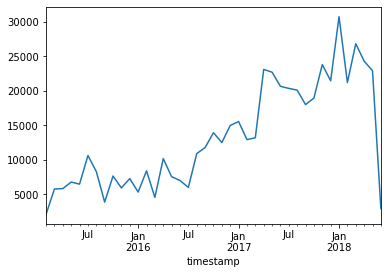

In [140]:
donations.groupby(pd.Grouper(freq='M')).amount.sum().plot() # had to revise from df to donations

### Taxi Example

In [141]:
def taxi_id_number(num_taxis):
    arr = np.arange(num_taxis)
    np.random.shuffle(arr)
    for i in range(num_taxis):
        yield arr[i]

In [142]:
# Now do for the shifts

def shift_info():
    start_times_and_freqs = [(0,8), (8,30), (16,15)]
    indices = np.arange(len(start_times_and_freqs))
    while True:
        idx = np.random.choice(indices, p = [0.25, 0.5, 0.25])
        start = start_times_and_freqs[idx]
        yield (start[0], start[0] + 7.5, start[1])

In [162]:
# More complex generator - to generate a time series of points for individual taxi

def taxi_process(taxi_id_generator, shift_info_generator):
    taxi_id = next(taxi_id_generator)
    shift_start, shift_end, shift_mean_trips = next(shift_info_generator)
    actual_trips = round(np.random.normal(loc = shift_mean_trips, scale=2))
    
    average_trip_time = 6.5 / shift_mean_trips * 60
    # mean trip time to minutes
    between_events_time = 1.0 / (shift_mean_trips - 1) * 60
    # assume cabs are seldom unused
    time = shift_start
    yield TimePoint(taxi_id, 'start shift', time)
    deltaT = np.random.poisson(between_events_time) / 60
    time += deltaT
    
    for i in range(actual_trips):
        yield TimePoint(taxi_id, 'pick up   ', time)
        deltaT = np.random.poisson(average_trip_time) / 60
        time += deltaT
        yield TimePoint(taxi_id, 'drop off   ', time)
        deltaT = np.random.poisson(between_events_time) / 60
        time += deltaT
    
    deltaT = np.random.poisson(between_events_time) / 60
    time += deltaT
    yield TimePoint(taxi_id, 'end shift   ', time)

In [175]:
# for TimePoint generator

from dataclasses import dataclass

@dataclass
class TimePoint:
    taxi_id: int
    name: str
    time: float
        
    def __lt__(self, other):
        return self.time < other.time

In [179]:
import queue

class Simulator:
    def __init__(self, num_taxis):
        self._time_points = queue.PriorityQueue()
        taxi_id_generator = taxi_id_number(num_taxis)
        shift_info_generator = shift_info()
        self._taxis = [taxi_process(taxi_id_generator, 
                                    shift_info_generator) for i in range(num_taxis)]        
        self._prepare_run()        

    def _prepare_run(self):
        for t in self._taxis:
            while True:
                try:
                    e = next(t)
                    self._time_points.put(e)
                except:
                    break        

    def run(self):
        sim_time = 0
        while sim_time < 24:
            if self._time_points.empty():
                break
            p = self._time_points.get()
            sim_time = p.time
            print(p)

In [177]:
sim = Simulator(1000)
sim.run()

TimePoint(taxi_id=818, name='start shift', time=0)
TimePoint(taxi_id=623, name='start shift', time=0)
TimePoint(taxi_id=444, name='start shift', time=0)
TimePoint(taxi_id=293, name='start shift', time=0)
TimePoint(taxi_id=706, name='start shift', time=0)
TimePoint(taxi_id=167, name='start shift', time=0)
TimePoint(taxi_id=687, name='start shift', time=0)
TimePoint(taxi_id=272, name='start shift', time=0)
TimePoint(taxi_id=9, name='start shift', time=0)
TimePoint(taxi_id=700, name='start shift', time=0)
TimePoint(taxi_id=912, name='start shift', time=0)
TimePoint(taxi_id=836, name='start shift', time=0)
TimePoint(taxi_id=824, name='start shift', time=0)
TimePoint(taxi_id=680, name='start shift', time=0)
TimePoint(taxi_id=32, name='start shift', time=0)
TimePoint(taxi_id=159, name='start shift', time=0)
TimePoint(taxi_id=527, name='start shift', time=0)
TimePoint(taxi_id=742, name='start shift', time=0)
TimePoint(taxi_id=391, name='start shift', time=0)
TimePoint(taxi_id=43, name='start 

TimePoint(taxi_id=115, name='pick up   ', time=2.933333333333333)
TimePoint(taxi_id=229, name='drop off   ', time=2.933333333333333)
TimePoint(taxi_id=81, name='pick up   ', time=2.933333333333333)
TimePoint(taxi_id=690, name='pick up   ', time=2.9333333333333336)
TimePoint(taxi_id=721, name='pick up   ', time=2.9333333333333336)
TimePoint(taxi_id=406, name='pick up   ', time=2.9333333333333336)
TimePoint(taxi_id=669, name='drop off   ', time=2.9333333333333336)
TimePoint(taxi_id=793, name='pick up   ', time=2.9333333333333336)
TimePoint(taxi_id=328, name='drop off   ', time=2.9333333333333336)
TimePoint(taxi_id=280, name='pick up   ', time=2.9499999999999997)
TimePoint(taxi_id=694, name='drop off   ', time=2.95)
TimePoint(taxi_id=985, name='pick up   ', time=2.95)
TimePoint(taxi_id=504, name='drop off   ', time=2.95)
TimePoint(taxi_id=604, name='drop off   ', time=2.95)
TimePoint(taxi_id=619, name='pick up   ', time=2.9666666666666663)
TimePoint(taxi_id=612, name='pick up   ', time=2.

TimePoint(taxi_id=864, name='drop off   ', time=6.066666666666666)
TimePoint(taxi_id=681, name='drop off   ', time=6.066666666666666)
TimePoint(taxi_id=345, name='pick up   ', time=6.066666666666667)
TimePoint(taxi_id=283, name='pick up   ', time=6.083333333333333)
TimePoint(taxi_id=82, name='pick up   ', time=6.083333333333333)
TimePoint(taxi_id=444, name='pick up   ', time=6.083333333333333)
TimePoint(taxi_id=312, name='drop off   ', time=6.083333333333334)
TimePoint(taxi_id=328, name='pick up   ', time=6.083333333333334)
TimePoint(taxi_id=527, name='pick up   ', time=6.1)
TimePoint(taxi_id=159, name='drop off   ', time=6.1)
TimePoint(taxi_id=577, name='drop off   ', time=6.1)
TimePoint(taxi_id=274, name='pick up   ', time=6.1)
TimePoint(taxi_id=124, name='drop off   ', time=6.1000000000000005)
TimePoint(taxi_id=395, name='drop off   ', time=6.1000000000000005)
TimePoint(taxi_id=802, name='pick up   ', time=6.116666666666666)
TimePoint(taxi_id=723, name='pick up   ', time=6.116666666

TimePoint(taxi_id=415, name='pick up   ', time=8.033333333333333)
TimePoint(taxi_id=973, name='pick up   ', time=8.033333333333333)
TimePoint(taxi_id=313, name='pick up   ', time=8.033333333333333)
TimePoint(taxi_id=990, name='pick up   ', time=8.033333333333333)
TimePoint(taxi_id=567, name='pick up   ', time=8.033333333333333)
TimePoint(taxi_id=404, name='pick up   ', time=8.033333333333333)
TimePoint(taxi_id=42, name='pick up   ', time=8.033333333333333)
TimePoint(taxi_id=778, name='pick up   ', time=8.033333333333333)
TimePoint(taxi_id=137, name='pick up   ', time=8.033333333333333)
TimePoint(taxi_id=852, name='pick up   ', time=8.033333333333333)
TimePoint(taxi_id=646, name='pick up   ', time=8.033333333333333)
TimePoint(taxi_id=446, name='pick up   ', time=8.033333333333333)
TimePoint(taxi_id=401, name='pick up   ', time=8.033333333333333)
TimePoint(taxi_id=601, name='pick up   ', time=8.033333333333333)
TimePoint(taxi_id=389, name='pick up   ', time=8.033333333333333)
TimePoint(t

TimePoint(taxi_id=975, name='drop off   ', time=8.416666666666668)
TimePoint(taxi_id=905, name='drop off   ', time=8.416666666666668)
TimePoint(taxi_id=45, name='pick up   ', time=8.416666666666668)
TimePoint(taxi_id=225, name='pick up   ', time=8.416666666666668)
TimePoint(taxi_id=433, name='pick up   ', time=8.41666666666667)
TimePoint(taxi_id=147, name='drop off   ', time=8.433333333333332)
TimePoint(taxi_id=606, name='drop off   ', time=8.433333333333332)
TimePoint(taxi_id=352, name='pick up   ', time=8.433333333333332)
TimePoint(taxi_id=566, name='drop off   ', time=8.433333333333332)
TimePoint(taxi_id=672, name='pick up   ', time=8.433333333333332)
TimePoint(taxi_id=672, name='drop off   ', time=8.433333333333332)
TimePoint(taxi_id=343, name='drop off   ', time=8.433333333333332)
TimePoint(taxi_id=20, name='drop off   ', time=8.433333333333332)
TimePoint(taxi_id=201, name='drop off   ', time=8.433333333333332)
TimePoint(taxi_id=761, name='drop off   ', time=8.433333333333334)
Tim

TimePoint(taxi_id=235, name='pick up   ', time=8.766666666666667)
TimePoint(taxi_id=133, name='drop off   ', time=8.766666666666667)
TimePoint(taxi_id=621, name='pick up   ', time=8.766666666666667)
TimePoint(taxi_id=397, name='drop off   ', time=8.766666666666667)
TimePoint(taxi_id=238, name='drop off   ', time=8.766666666666667)
TimePoint(taxi_id=904, name='drop off   ', time=8.766666666666667)
TimePoint(taxi_id=998, name='drop off   ', time=8.766666666666667)
TimePoint(taxi_id=137, name='pick up   ', time=8.766666666666667)
TimePoint(taxi_id=113, name='pick up   ', time=8.766666666666667)
TimePoint(taxi_id=66, name='drop off   ', time=8.766666666666667)
TimePoint(taxi_id=478, name='pick up   ', time=8.766666666666667)
TimePoint(taxi_id=891, name='drop off   ', time=8.766666666666667)
TimePoint(taxi_id=411, name='pick up   ', time=8.766666666666667)
TimePoint(taxi_id=411, name='drop off   ', time=8.766666666666667)
TimePoint(taxi_id=908, name='drop off   ', time=8.766666666666667)
Ti

TimePoint(taxi_id=66, name='drop off   ', time=9.116666666666667)
TimePoint(taxi_id=778, name='drop off   ', time=9.116666666666667)
TimePoint(taxi_id=784, name='drop off   ', time=9.116666666666667)
TimePoint(taxi_id=503, name='drop off   ', time=9.116666666666667)
TimePoint(taxi_id=124, name='end shift   ', time=9.116666666666667)
TimePoint(taxi_id=284, name='pick up   ', time=9.116666666666667)
TimePoint(taxi_id=456, name='pick up   ', time=9.116666666666669)
TimePoint(taxi_id=155, name='pick up   ', time=9.116666666666669)
TimePoint(taxi_id=311, name='drop off   ', time=9.116666666666669)
TimePoint(taxi_id=838, name='drop off   ', time=9.116666666666669)
TimePoint(taxi_id=471, name='pick up   ', time=9.116666666666669)
TimePoint(taxi_id=799, name='pick up   ', time=9.116666666666669)
TimePoint(taxi_id=559, name='pick up   ', time=9.116666666666669)
TimePoint(taxi_id=949, name='drop off   ', time=9.116666666666669)
TimePoint(taxi_id=656, name='pick up   ', time=9.116666666666669)
Ti

TimePoint(taxi_id=602, name='pick up   ', time=9.466666666666667)
TimePoint(taxi_id=602, name='drop off   ', time=9.466666666666667)
TimePoint(taxi_id=596, name='pick up   ', time=9.466666666666667)
TimePoint(taxi_id=596, name='drop off   ', time=9.466666666666667)
TimePoint(taxi_id=116, name='pick up   ', time=9.466666666666667)
TimePoint(taxi_id=255, name='pick up   ', time=9.466666666666667)
TimePoint(taxi_id=904, name='pick up   ', time=9.466666666666667)
TimePoint(taxi_id=503, name='pick up   ', time=9.466666666666667)
TimePoint(taxi_id=683, name='pick up   ', time=9.466666666666667)
TimePoint(taxi_id=683, name='drop off   ', time=9.466666666666667)
TimePoint(taxi_id=435, name='pick up   ', time=9.466666666666669)
TimePoint(taxi_id=19, name='pick up   ', time=9.466666666666669)
TimePoint(taxi_id=237, name='pick up   ', time=9.466666666666669)
TimePoint(taxi_id=165, name='pick up   ', time=9.466666666666669)
TimePoint(taxi_id=7, name='pick up   ', time=9.466666666666669)
TimePoint(

TimePoint(taxi_id=854, name='pick up   ', time=9.81666666666667)
TimePoint(taxi_id=735, name='drop off   ', time=9.81666666666667)
TimePoint(taxi_id=31, name='pick up   ', time=9.81666666666667)
TimePoint(taxi_id=997, name='pick up   ', time=9.81666666666667)
TimePoint(taxi_id=892, name='pick up   ', time=9.81666666666667)
TimePoint(taxi_id=892, name='drop off   ', time=9.81666666666667)
TimePoint(taxi_id=266, name='pick up   ', time=9.81666666666667)
TimePoint(taxi_id=2, name='pick up   ', time=9.81666666666667)
TimePoint(taxi_id=320, name='drop off   ', time=9.81666666666667)
TimePoint(taxi_id=826, name='drop off   ', time=9.81666666666667)
TimePoint(taxi_id=168, name='pick up   ', time=9.81666666666667)
TimePoint(taxi_id=646, name='drop off   ', time=9.81666666666667)
TimePoint(taxi_id=365, name='pick up   ', time=9.81666666666667)
TimePoint(taxi_id=214, name='pick up   ', time=9.81666666666667)
TimePoint(taxi_id=213, name='pick up   ', time=9.81666666666667)
TimePoint(taxi_id=500, 

TimePoint(taxi_id=42, name='pick up   ', time=10.16666666666667)
TimePoint(taxi_id=478, name='pick up   ', time=10.16666666666667)
TimePoint(taxi_id=176, name='drop off   ', time=10.16666666666667)
TimePoint(taxi_id=926, name='pick up   ', time=10.16666666666667)
TimePoint(taxi_id=188, name='pick up   ', time=10.166666666666671)
TimePoint(taxi_id=69, name='drop off   ', time=10.166666666666671)
TimePoint(taxi_id=269, name='pick up   ', time=10.166666666666671)
TimePoint(taxi_id=266, name='pick up   ', time=10.166666666666671)
TimePoint(taxi_id=920, name='pick up   ', time=10.166666666666671)
TimePoint(taxi_id=320, name='drop off   ', time=10.166666666666671)
TimePoint(taxi_id=198, name='drop off   ', time=10.166666666666671)
TimePoint(taxi_id=102, name='drop off   ', time=10.166666666666671)
TimePoint(taxi_id=897, name='pick up   ', time=10.166666666666671)
TimePoint(taxi_id=981, name='pick up   ', time=10.166666666666673)
TimePoint(taxi_id=670, name='pick up   ', time=10.1666666666666

TimePoint(taxi_id=890, name='pick up   ', time=10.533333333333337)
TimePoint(taxi_id=172, name='drop off   ', time=10.533333333333337)
TimePoint(taxi_id=174, name='pick up   ', time=10.533333333333337)
TimePoint(taxi_id=168, name='drop off   ', time=10.533333333333337)
TimePoint(taxi_id=375, name='pick up   ', time=10.533333333333337)
TimePoint(taxi_id=995, name='pick up   ', time=10.533333333333337)
TimePoint(taxi_id=699, name='pick up   ', time=10.533333333333337)
TimePoint(taxi_id=627, name='pick up   ', time=10.533333333333337)
TimePoint(taxi_id=470, name='drop off   ', time=10.533333333333337)
TimePoint(taxi_id=913, name='drop off   ', time=10.533333333333337)
TimePoint(taxi_id=865, name='pick up   ', time=10.533333333333337)
TimePoint(taxi_id=478, name='drop off   ', time=10.533333333333337)
TimePoint(taxi_id=214, name='drop off   ', time=10.533333333333337)
TimePoint(taxi_id=80, name='drop off   ', time=10.533333333333337)
TimePoint(taxi_id=483, name='drop off   ', time=10.53333

TimePoint(taxi_id=96, name='drop off   ', time=10.900000000000002)
TimePoint(taxi_id=809, name='pick up   ', time=10.900000000000002)
TimePoint(taxi_id=18, name='pick up   ', time=10.900000000000002)
TimePoint(taxi_id=492, name='drop off   ', time=10.900000000000002)
TimePoint(taxi_id=20, name='pick up   ', time=10.900000000000002)
TimePoint(taxi_id=737, name='drop off   ', time=10.900000000000002)
TimePoint(taxi_id=747, name='pick up   ', time=10.900000000000002)
TimePoint(taxi_id=747, name='drop off   ', time=10.900000000000002)
TimePoint(taxi_id=810, name='pick up   ', time=10.900000000000002)
TimePoint(taxi_id=737, name='pick up   ', time=10.900000000000002)
TimePoint(taxi_id=255, name='drop off   ', time=10.900000000000002)
TimePoint(taxi_id=995, name='drop off   ', time=10.900000000000002)
TimePoint(taxi_id=970, name='pick up   ', time=10.900000000000002)
TimePoint(taxi_id=601, name='pick up   ', time=10.900000000000002)
TimePoint(taxi_id=15, name='drop off   ', time=10.900000000

TimePoint(taxi_id=611, name='pick up   ', time=11.250000000000005)
TimePoint(taxi_id=571, name='drop off   ', time=11.250000000000005)
TimePoint(taxi_id=63, name='pick up   ', time=11.250000000000005)
TimePoint(taxi_id=338, name='pick up   ', time=11.250000000000005)
TimePoint(taxi_id=276, name='drop off   ', time=11.250000000000005)
TimePoint(taxi_id=677, name='pick up   ', time=11.250000000000005)
TimePoint(taxi_id=677, name='drop off   ', time=11.250000000000005)
TimePoint(taxi_id=875, name='pick up   ', time=11.250000000000005)
TimePoint(taxi_id=827, name='pick up   ', time=11.250000000000005)
TimePoint(taxi_id=765, name='drop off   ', time=11.250000000000005)
TimePoint(taxi_id=65, name='drop off   ', time=11.250000000000005)
TimePoint(taxi_id=833, name='drop off   ', time=11.250000000000005)
TimePoint(taxi_id=886, name='pick up   ', time=11.250000000000005)
TimePoint(taxi_id=478, name='pick up   ', time=11.250000000000005)
TimePoint(taxi_id=698, name='pick up   ', time=11.25000000

TimePoint(taxi_id=329, name='pick up   ', time=11.616666666666669)
TimePoint(taxi_id=951, name='pick up   ', time=11.616666666666669)
TimePoint(taxi_id=839, name='drop off   ', time=11.616666666666669)
TimePoint(taxi_id=83, name='drop off   ', time=11.616666666666669)
TimePoint(taxi_id=520, name='drop off   ', time=11.616666666666669)
TimePoint(taxi_id=194, name='pick up   ', time=11.616666666666669)
TimePoint(taxi_id=781, name='drop off   ', time=11.616666666666669)
TimePoint(taxi_id=695, name='drop off   ', time=11.616666666666669)
TimePoint(taxi_id=299, name='pick up   ', time=11.616666666666669)
TimePoint(taxi_id=20, name='drop off   ', time=11.616666666666669)
TimePoint(taxi_id=70, name='drop off   ', time=11.616666666666669)
TimePoint(taxi_id=628, name='pick up   ', time=11.616666666666669)
TimePoint(taxi_id=820, name='drop off   ', time=11.616666666666669)
TimePoint(taxi_id=602, name='drop off   ', time=11.616666666666669)
TimePoint(taxi_id=621, name='pick up   ', time=11.616666

TimePoint(taxi_id=587, name='drop off   ', time=11.966666666666672)
TimePoint(taxi_id=880, name='drop off   ', time=11.966666666666672)
TimePoint(taxi_id=862, name='drop off   ', time=11.966666666666672)
TimePoint(taxi_id=595, name='pick up   ', time=11.966666666666672)
TimePoint(taxi_id=808, name='drop off   ', time=11.966666666666672)
TimePoint(taxi_id=470, name='drop off   ', time=11.966666666666672)
TimePoint(taxi_id=817, name='pick up   ', time=11.966666666666672)
TimePoint(taxi_id=964, name='drop off   ', time=11.966666666666672)
TimePoint(taxi_id=92, name='drop off   ', time=11.966666666666674)
TimePoint(taxi_id=63, name='pick up   ', time=11.966666666666674)
TimePoint(taxi_id=393, name='pick up   ', time=11.966666666666674)
TimePoint(taxi_id=875, name='drop off   ', time=11.966666666666674)
TimePoint(taxi_id=105, name='drop off   ', time=11.966666666666674)
TimePoint(taxi_id=294, name='pick up   ', time=11.966666666666674)
TimePoint(taxi_id=896, name='pick up   ', time=11.96666

TimePoint(taxi_id=614, name='drop off   ', time=12.333333333333336)
TimePoint(taxi_id=841, name='drop off   ', time=12.333333333333336)
TimePoint(taxi_id=520, name='pick up   ', time=12.333333333333336)
TimePoint(taxi_id=920, name='pick up   ', time=12.333333333333336)
TimePoint(taxi_id=299, name='drop off   ', time=12.333333333333336)
TimePoint(taxi_id=794, name='drop off   ', time=12.333333333333336)
TimePoint(taxi_id=180, name='drop off   ', time=12.333333333333336)
TimePoint(taxi_id=101, name='pick up   ', time=12.333333333333336)
TimePoint(taxi_id=437, name='drop off   ', time=12.333333333333336)
TimePoint(taxi_id=621, name='pick up   ', time=12.333333333333336)
TimePoint(taxi_id=360, name='drop off   ', time=12.333333333333336)
TimePoint(taxi_id=375, name='drop off   ', time=12.333333333333337)
TimePoint(taxi_id=215, name='drop off   ', time=12.333333333333337)
TimePoint(taxi_id=809, name='drop off   ', time=12.333333333333337)
TimePoint(taxi_id=892, name='pick up   ', time=12.33

TimePoint(taxi_id=834, name='pick up   ', time=12.66666666666667)
TimePoint(taxi_id=427, name='pick up   ', time=12.66666666666667)
TimePoint(taxi_id=150, name='drop off   ', time=12.66666666666667)
TimePoint(taxi_id=243, name='pick up   ', time=12.66666666666667)
TimePoint(taxi_id=820, name='drop off   ', time=12.66666666666667)
TimePoint(taxi_id=66, name='pick up   ', time=12.66666666666667)
TimePoint(taxi_id=430, name='drop off   ', time=12.66666666666667)
TimePoint(taxi_id=520, name='pick up   ', time=12.66666666666667)
TimePoint(taxi_id=997, name='pick up   ', time=12.66666666666667)
TimePoint(taxi_id=503, name='drop off   ', time=12.66666666666667)
TimePoint(taxi_id=194, name='pick up   ', time=12.66666666666667)
TimePoint(taxi_id=166, name='pick up   ', time=12.66666666666667)
TimePoint(taxi_id=610, name='drop off   ', time=12.66666666666667)
TimePoint(taxi_id=507, name='drop off   ', time=12.66666666666667)
TimePoint(taxi_id=437, name='pick up   ', time=12.66666666666667)
TimeP

TimePoint(taxi_id=69, name='drop off   ', time=12.983333333333341)
TimePoint(taxi_id=581, name='pick up   ', time=12.983333333333341)
TimePoint(taxi_id=346, name='pick up   ', time=12.983333333333341)
TimePoint(taxi_id=292, name='pick up   ', time=12.983333333333341)
TimePoint(taxi_id=407, name='drop off   ', time=12.983333333333341)
TimePoint(taxi_id=754, name='drop off   ', time=12.983333333333341)
TimePoint(taxi_id=69, name='pick up   ', time=12.983333333333341)
TimePoint(taxi_id=581, name='drop off   ', time=12.983333333333341)
TimePoint(taxi_id=573, name='pick up   ', time=12.983333333333341)
TimePoint(taxi_id=96, name='pick up   ', time=12.983333333333341)
TimePoint(taxi_id=508, name='drop off   ', time=12.983333333333341)
TimePoint(taxi_id=128, name='pick up   ', time=12.983333333333341)
TimePoint(taxi_id=613, name='pick up   ', time=12.983333333333343)
TimePoint(taxi_id=6, name='drop off   ', time=12.983333333333343)
TimePoint(taxi_id=238, name='pick up   ', time=12.98333333333

TimePoint(taxi_id=684, name='pick up   ', time=13.316666666666674)
TimePoint(taxi_id=390, name='pick up   ', time=13.316666666666674)
TimePoint(taxi_id=948, name='drop off   ', time=13.316666666666674)
TimePoint(taxi_id=662, name='drop off   ', time=13.316666666666674)
TimePoint(taxi_id=959, name='pick up   ', time=13.316666666666674)
TimePoint(taxi_id=995, name='drop off   ', time=13.316666666666674)
TimePoint(taxi_id=493, name='pick up   ', time=13.316666666666674)
TimePoint(taxi_id=493, name='drop off   ', time=13.316666666666674)
TimePoint(taxi_id=79, name='pick up   ', time=13.316666666666674)
TimePoint(taxi_id=817, name='pick up   ', time=13.316666666666674)
TimePoint(taxi_id=313, name='drop off   ', time=13.316666666666674)
TimePoint(taxi_id=743, name='drop off   ', time=13.316666666666674)
TimePoint(taxi_id=192, name='drop off   ', time=13.316666666666674)
TimePoint(taxi_id=851, name='pick up   ', time=13.316666666666675)
TimePoint(taxi_id=851, name='drop off   ', time=13.31666

TimePoint(taxi_id=510, name='drop off   ', time=13.666666666666673)
TimePoint(taxi_id=189, name='pick up   ', time=13.666666666666673)
TimePoint(taxi_id=478, name='pick up   ', time=13.666666666666673)
TimePoint(taxi_id=638, name='pick up   ', time=13.666666666666673)
TimePoint(taxi_id=574, name='drop off   ', time=13.666666666666675)
TimePoint(taxi_id=981, name='pick up   ', time=13.666666666666675)
TimePoint(taxi_id=851, name='pick up   ', time=13.666666666666675)
TimePoint(taxi_id=494, name='pick up   ', time=13.666666666666675)
TimePoint(taxi_id=292, name='drop off   ', time=13.666666666666675)
TimePoint(taxi_id=875, name='pick up   ', time=13.666666666666675)
TimePoint(taxi_id=573, name='pick up   ', time=13.666666666666675)
TimePoint(taxi_id=890, name='pick up   ', time=13.666666666666675)
TimePoint(taxi_id=65, name='pick up   ', time=13.666666666666675)
TimePoint(taxi_id=375, name='pick up   ', time=13.666666666666675)
TimePoint(taxi_id=975, name='pick up   ', time=13.6666666666

TimePoint(taxi_id=576, name='drop off   ', time=13.96666666666668)
TimePoint(taxi_id=10, name='pick up   ', time=13.96666666666668)
TimePoint(taxi_id=351, name='drop off   ', time=13.966666666666681)
TimePoint(taxi_id=351, name='pick up   ', time=13.966666666666681)
TimePoint(taxi_id=354, name='pick up   ', time=13.983333333333327)
TimePoint(taxi_id=352, name='drop off   ', time=13.983333333333333)
TimePoint(taxi_id=580, name='drop off   ', time=13.983333333333333)
TimePoint(taxi_id=120, name='drop off   ', time=13.983333333333334)
TimePoint(taxi_id=552, name='pick up   ', time=13.983333333333334)
TimePoint(taxi_id=713, name='pick up   ', time=13.983333333333334)
TimePoint(taxi_id=19, name='pick up   ', time=13.983333333333336)
TimePoint(taxi_id=740, name='drop off   ', time=13.983333333333336)
TimePoint(taxi_id=112, name='pick up   ', time=13.983333333333336)
TimePoint(taxi_id=541, name='drop off   ', time=13.983333333333336)
TimePoint(taxi_id=609, name='drop off   ', time=13.98333333

TimePoint(taxi_id=642, name='pick up   ', time=14.300000000000002)
TimePoint(taxi_id=360, name='drop off   ', time=14.300000000000002)
TimePoint(taxi_id=471, name='drop off   ', time=14.300000000000002)
TimePoint(taxi_id=562, name='pick up   ', time=14.300000000000002)
TimePoint(taxi_id=920, name='pick up   ', time=14.300000000000002)
TimePoint(taxi_id=435, name='pick up   ', time=14.300000000000002)
TimePoint(taxi_id=97, name='pick up   ', time=14.300000000000004)
TimePoint(taxi_id=340, name='pick up   ', time=14.300000000000004)
TimePoint(taxi_id=863, name='drop off   ', time=14.300000000000004)
TimePoint(taxi_id=338, name='drop off   ', time=14.300000000000004)
TimePoint(taxi_id=303, name='pick up   ', time=14.300000000000004)
TimePoint(taxi_id=872, name='pick up   ', time=14.300000000000004)
TimePoint(taxi_id=827, name='pick up   ', time=14.300000000000004)
TimePoint(taxi_id=4, name='drop off   ', time=14.300000000000004)
TimePoint(taxi_id=329, name='drop off   ', time=14.300000000

TimePoint(taxi_id=135, name='pick up   ', time=14.633333333333331)
TimePoint(taxi_id=771, name='drop off   ', time=14.633333333333333)
TimePoint(taxi_id=119, name='drop off   ', time=14.633333333333333)
TimePoint(taxi_id=622, name='pick up   ', time=14.633333333333335)
TimePoint(taxi_id=999, name='drop off   ', time=14.633333333333335)
TimePoint(taxi_id=853, name='pick up   ', time=14.633333333333335)
TimePoint(taxi_id=622, name='drop off   ', time=14.633333333333335)
TimePoint(taxi_id=535, name='drop off   ', time=14.633333333333335)
TimePoint(taxi_id=318, name='pick up   ', time=14.633333333333336)
TimePoint(taxi_id=747, name='pick up   ', time=14.633333333333336)
TimePoint(taxi_id=182, name='drop off   ', time=14.633333333333336)
TimePoint(taxi_id=460, name='drop off   ', time=14.633333333333336)
TimePoint(taxi_id=849, name='pick up   ', time=14.633333333333336)
TimePoint(taxi_id=38, name='pick up   ', time=14.633333333333336)
TimePoint(taxi_id=57, name='end shift   ', time=14.63333

TimePoint(taxi_id=419, name='pick up   ', time=14.983333333333341)
TimePoint(taxi_id=558, name='drop off   ', time=14.983333333333341)
TimePoint(taxi_id=443, name='pick up   ', time=14.983333333333341)
TimePoint(taxi_id=76, name='pick up   ', time=14.983333333333341)
TimePoint(taxi_id=128, name='drop off   ', time=14.983333333333341)
TimePoint(taxi_id=257, name='drop off   ', time=14.983333333333341)
TimePoint(taxi_id=134, name='end shift   ', time=14.983333333333341)
TimePoint(taxi_id=386, name='drop off   ', time=14.983333333333341)
TimePoint(taxi_id=339, name='pick up   ', time=14.983333333333341)
TimePoint(taxi_id=662, name='drop off   ', time=14.983333333333341)
TimePoint(taxi_id=365, name='drop off   ', time=14.983333333333341)
TimePoint(taxi_id=189, name='pick up   ', time=14.983333333333341)
TimePoint(taxi_id=301, name='drop off   ', time=14.983333333333343)
TimePoint(taxi_id=991, name='pick up   ', time=14.983333333333343)
TimePoint(taxi_id=18, name='pick up   ', time=14.98333

TimePoint(taxi_id=860, name='drop off   ', time=15.583333333333343)
TimePoint(taxi_id=586, name='pick up   ', time=15.583333333333343)
TimePoint(taxi_id=401, name='drop off   ', time=15.583333333333343)
TimePoint(taxi_id=587, name='drop off   ', time=15.583333333333343)
TimePoint(taxi_id=431, name='end shift   ', time=15.583333333333345)
TimePoint(taxi_id=171, name='drop off   ', time=15.583333333333345)
TimePoint(taxi_id=142, name='pick up   ', time=15.583333333333345)
TimePoint(taxi_id=581, name='drop off   ', time=15.583333333333345)
TimePoint(taxi_id=235, name='pick up   ', time=15.583333333333345)
TimePoint(taxi_id=195, name='drop off   ', time=15.583333333333346)
TimePoint(taxi_id=6, name='end shift   ', time=15.583333333333348)
TimePoint(taxi_id=192, name='end shift   ', time=15.583333333333348)
TimePoint(taxi_id=555, name='drop off   ', time=15.58333333333335)
TimePoint(taxi_id=118, name='pick up   ', time=15.600000000000001)
TimePoint(taxi_id=250, name='pick up   ', time=15.60

TimePoint(taxi_id=902, name='drop off   ', time=16.383333333333333)
TimePoint(taxi_id=550, name='drop off   ', time=16.383333333333336)
TimePoint(taxi_id=332, name='drop off   ', time=16.383333333333336)
TimePoint(taxi_id=650, name='pick up   ', time=16.38333333333334)
TimePoint(taxi_id=704, name='end shift   ', time=16.38333333333334)
TimePoint(taxi_id=862, name='drop off   ', time=16.383333333333344)
TimePoint(taxi_id=618, name='drop off   ', time=16.4)
TimePoint(taxi_id=590, name='drop off   ', time=16.4)
TimePoint(taxi_id=153, name='drop off   ', time=16.400000000000002)
TimePoint(taxi_id=626, name='end shift   ', time=16.400000000000002)
TimePoint(taxi_id=815, name='drop off   ', time=16.400000000000002)
TimePoint(taxi_id=644, name='drop off   ', time=16.400000000000002)
TimePoint(taxi_id=100, name='drop off   ', time=16.400000000000002)
TimePoint(taxi_id=889, name='pick up   ', time=16.400000000000002)
TimePoint(taxi_id=753, name='drop off   ', time=16.400000000000002)
TimePoint(

TimePoint(taxi_id=804, name='pick up   ', time=17.733333333333334)
TimePoint(taxi_id=901, name='drop off   ', time=17.733333333333334)
TimePoint(taxi_id=678, name='pick up   ', time=17.733333333333334)
TimePoint(taxi_id=590, name='pick up   ', time=17.733333333333334)
TimePoint(taxi_id=228, name='drop off   ', time=17.733333333333334)
TimePoint(taxi_id=671, name='drop off   ', time=17.733333333333334)
TimePoint(taxi_id=234, name='drop off   ', time=17.733333333333334)
TimePoint(taxi_id=3, name='pick up   ', time=17.733333333333334)
TimePoint(taxi_id=413, name='pick up   ', time=17.733333333333338)
TimePoint(taxi_id=780, name='drop off   ', time=17.749999999999996)
TimePoint(taxi_id=605, name='drop off   ', time=17.75)
TimePoint(taxi_id=73, name='drop off   ', time=17.75)
TimePoint(taxi_id=100, name='drop off   ', time=17.75)
TimePoint(taxi_id=744, name='drop off   ', time=17.75)
TimePoint(taxi_id=825, name='pick up   ', time=17.75)
TimePoint(taxi_id=84, name='pick up   ', time=17.75)
T

TimePoint(taxi_id=122, name='pick up   ', time=19.316666666666666)
TimePoint(taxi_id=634, name='pick up   ', time=19.316666666666666)
TimePoint(taxi_id=417, name='pick up   ', time=19.31666666666667)
TimePoint(taxi_id=148, name='drop off   ', time=19.31666666666667)
TimePoint(taxi_id=590, name='pick up   ', time=19.31666666666667)
TimePoint(taxi_id=550, name='pick up   ', time=19.31666666666667)
TimePoint(taxi_id=22, name='pick up   ', time=19.31666666666667)
TimePoint(taxi_id=766, name='drop off   ', time=19.31666666666667)
TimePoint(taxi_id=221, name='pick up   ', time=19.316666666666674)
TimePoint(taxi_id=162, name='drop off   ', time=19.316666666666674)
TimePoint(taxi_id=234, name='drop off   ', time=19.316666666666674)
TimePoint(taxi_id=392, name='drop off   ', time=19.333333333333332)
TimePoint(taxi_id=326, name='pick up   ', time=19.333333333333332)
TimePoint(taxi_id=568, name='drop off   ', time=19.333333333333332)
TimePoint(taxi_id=372, name='pick up   ', time=19.3333333333333

TimePoint(taxi_id=767, name='drop off   ', time=20.88333333333333)
TimePoint(taxi_id=29, name='drop off   ', time=20.88333333333333)
TimePoint(taxi_id=744, name='drop off   ', time=20.88333333333333)
TimePoint(taxi_id=330, name='drop off   ', time=20.883333333333333)
TimePoint(taxi_id=639, name='drop off   ', time=20.883333333333333)
TimePoint(taxi_id=554, name='drop off   ', time=20.883333333333333)
TimePoint(taxi_id=100, name='drop off   ', time=20.883333333333333)
TimePoint(taxi_id=893, name='pick up   ', time=20.883333333333333)
TimePoint(taxi_id=216, name='drop off   ', time=20.883333333333336)
TimePoint(taxi_id=548, name='pick up   ', time=20.883333333333336)
TimePoint(taxi_id=534, name='pick up   ', time=20.88333333333334)
TimePoint(taxi_id=384, name='drop off   ', time=20.88333333333334)
TimePoint(taxi_id=62, name='pick up   ', time=20.88333333333334)
TimePoint(taxi_id=630, name='pick up   ', time=20.88333333333334)
TimePoint(taxi_id=881, name='pick up   ', time=20.883333333333

TimePoint(taxi_id=377, name='pick up   ', time=22.450000000000014)
TimePoint(taxi_id=209, name='drop off   ', time=22.46666666666666)
TimePoint(taxi_id=363, name='pick up   ', time=22.466666666666665)
TimePoint(taxi_id=947, name='pick up   ', time=22.466666666666665)
TimePoint(taxi_id=678, name='drop off   ', time=22.466666666666665)
TimePoint(taxi_id=468, name='drop off   ', time=22.466666666666665)
TimePoint(taxi_id=409, name='drop off   ', time=22.466666666666665)
TimePoint(taxi_id=633, name='drop off   ', time=22.466666666666665)
TimePoint(taxi_id=529, name='end shift   ', time=22.46666666666667)
TimePoint(taxi_id=12, name='drop off   ', time=22.46666666666667)
TimePoint(taxi_id=457, name='pick up   ', time=22.46666666666667)
TimePoint(taxi_id=109, name='pick up   ', time=22.46666666666667)
TimePoint(taxi_id=590, name='drop off   ', time=22.46666666666667)
TimePoint(taxi_id=927, name='drop off   ', time=22.466666666666672)
TimePoint(taxi_id=136, name='drop off   ', time=22.46666666

In [168]:
sim

### Ising Model Example

In [180]:
N = 5 # width of lattice
M = 5 # height of lattice
# temp settings
temperature = 0.5
BETA = 1 / temperature

In [181]:
def initRandState(N, M):
    block = np.random.choice([-1,1], size = (N, M))
    return block

In [183]:
def costForCenterState(state, i, j, n, m):
    centerS = state[i,j]
    neighbors = [((i + 1) % n, j), ((i - 1) % n, j),
                (i, (j + 1) % m), (i, (j - 1) % m)]
    interactionE = [state[x,y] * centerS for (x,y) in neighbors]
    return np.sum(interactionE)

In [184]:
def magnetizationForState(state):
    return np.sum(state)

In [185]:
# MCMC steps

def mcmcAdjust(state):
    n = state.shape[0]
    m = state.shape[1]
    x, y = np.random.randint(0, n), np.random.randint(0, m)
    centerS = state[x,y]
    cost = costForCenterState(state, x, y, n, m)
    if cost < 0:
        centerS *= -1
    elif np.random.random() < np.exp(-cost * BETA):
        centerS *= -1
    state[x,y] = centerS
    return state

In [186]:
def runState(state, n_steps, snapsteps = None):
    if snapsteps is None:
        snapsteps = np.linspace(0, n_steps, num = round(n_steps / (M * N * 100)), dtype = np.int32)
    saved_states = []
    sp = 0
    magnet_hist = []
    for i in range(n_steps):
        state = mcmcAdjust(state)
        magnet_hist.append(magnetizationForState(state))
        if sp < len(snapsteps) and i == snapsteps[sp]:
            saved_states.append(np.copy(state))
            sp += 1
    return state, saved_states, magnet_hist

In [187]:
# Simulation Time!
init_state = initRandState(N, M)

In [188]:
print(init_state)

[[ 1  1 -1 -1 -1]
 [ 1 -1 -1  1 -1]
 [-1 -1 -1 -1 -1]
 [-1 -1  1  1  1]
 [-1 -1  1 -1 -1]]


In [190]:
final_state = runState(np.copy(init_state), 1000)

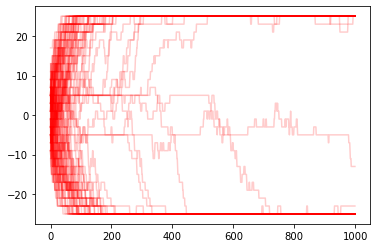

In [192]:
# Results
results = []
for i in range(100):
    init_state = initRandState(N,M)
    final_state, states, magnet_hist = runState(init_state, 1000)
    results.append(magnet_hist)

import matplotlib.pyplot as plt
for mh in results:
    plt.plot(mh,'r', alpha=0.2)